<a href="https://colab.research.google.com/github/vishkaush/misc-projects/blob/main/Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Blocks

In [201]:
import numpy as np
def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  cache = Z
  return A, cache  # returns in cache what it receives

In [202]:
def relu(Z):
  A = np.maximum(0, Z)
  cache = Z
  return A, cache

In [232]:
def initialize_parameters(layer_dims):
  # layer_dims is a list containing no. of nodes in layer 0 to L
  np.random.seed(1)
  parameters = {}
  num_layers = len(layer_dims) # includes input layer and output layer
  for l in range(1, num_layers):
    parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01  #/ np.sqrt(layer_dims[l-1])
    parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
  return parameters

In [204]:
def linear_forward(A_prev, W, b):
  # A_prev - activation from previous layer
  # W - weight matrix for this layer
  # b - bias for this layer
  Z = np.dot(W,A_prev)+b
  cache = (A_prev, W, b)
  assert(Z.shape == (W.shape[0], A_prev.shape[1]))
  return Z, cache  # returns in cache what it receives

In [205]:
def linear_activation_forward(A_prev, W, b, activation):
  if activation == "sigmoid":
    Z, linear_cache = linear_forward(A_prev, W, b)  
    A, activation_cache = sigmoid(Z)
  elif activation == "relu":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)
  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  cache = (linear_cache, activation_cache)  # will contain A_prev, W, b, Z
  return A, cache

In [206]:
def model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters)//2  # no. of layers in the network excluding input layer
  for l in range(1, L):
    A_prev = A
    A, cache= linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
    caches.append(cache)
  
  AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
  caches.append(cache)
  assert(AL.shape==(1,X.shape[1]))
  return AL, caches

In [207]:
def compute_cost(AL, y):
  m = y.shape[1]
  logprobs = np.multiply(np.log(AL),y)+np.multiply((1-y),np.log(1-AL))
  cost = -(1/m)*np.sum(logprobs)
  cost = np.squeeze(cost)    #type = np.float64
  assert(cost.shape==())
  return cost

## Backprop
<img width=400 height=300 src='https://drive.google.com/uc?id=1sreixqIgj_JOLL2s7EChxbjPN_jRP8Yt'>

In [208]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = (1./m)*np.dot(dZ, A_prev.T)
  db = (1./m)*dZ.sum(axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)
  assert(dA_prev.shape==A_prev.shape)
  assert(dW.shape==W.shape)
  assert(db.shape==b.shape)
  return dA_prev, dW, db

In [209]:
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  assert(dZ.shape == Z.shape)
  return dZ

In [210]:
def sigmoid_backward(dA, cache):
  Z = cache
  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)
  assert(dZ.shape == Z.shape)
  return dZ

In [211]:
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  if activation == "relu":
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  elif activation == "sigmoid":
    dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db

In [212]:
def model_backward(AL, y, caches):
  grads = {}
  L = len(caches) # number of layers excluding the input layer
  m = AL.shape[1]
  #y = y.reshape(AL.shape)
  assert(y.shape == AL.shape)
  dAL = - (np.divide(y, AL) - np.divide(1 - y, 1 - AL))
  current_cache = caches[L-1]
  #print("Calling backward for layer ", str(L))
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
  for l in reversed(range(1, L)):
    current_cache = caches[l-1]
    #print("Calling backward for layer ", str(l))
    grads["dA" + str(l-1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward(grads["dA" + str(l)], current_cache, "relu")
  return grads

In [213]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters) // 2
  for l in range(1, L+1):
      parameters['W' + str(l)] = parameters['W' + str(l)]-learning_rate*grads['dW' + str(l)]
      parameters['b' + str(l)] = parameters['b' + str(l)]-learning_rate*grads['db' + str(l)]
  return parameters

In [214]:
def predict(X, parameters):
  probs, _ = model_forward(X, parameters)
  predictions = np.where(probs > 0.5, 1.0, 0.0)
  return predictions

# Load and Pre Process Data

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
import numpy as np
import h5py

train_dataset = h5py.File('/content/drive/MyDrive/andrew_dl_data/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels
print("train_set_x_orig's shape = ", train_set_x_orig.shape)
print("train_set_y_orig's shape = ", train_set_y_orig.shape)

test_dataset = h5py.File('/content/drive/MyDrive/andrew_dl_data/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels
print("test_set_x_orig's shape = ", test_set_x_orig.shape)
print("test_set_y_orig's shape = ", test_set_y_orig.shape)

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
print("classes = ", classes)

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

train_set_x_orig's shape =  (209, 64, 64, 3)
train_set_y_orig's shape =  (209,)
test_set_x_orig's shape =  (50, 64, 64, 3)
test_set_y_orig's shape =  (50,)
classes =  [b'non-cat' b'cat']


Label of this image =  0  that is 'non-cat '


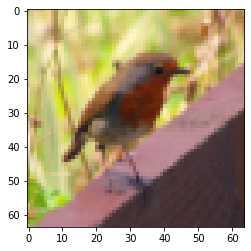

In [217]:
import matplotlib.pyplot as plt
index = 10
plt.imshow(train_set_x_orig[index])
print("Label of this image = ", train_set_y_orig[0, index], " that is '" + classes[train_set_y_orig[0, index]].decode("utf-8"), "'")

In [218]:
# Now we want to flatten the images to form train matrix of shape (64*64*3, 209)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [219]:
# one common pre-processing step is to do (x-\mu)/\sigma
# But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

train_set_X = train_set_x_flatten/255.
test_set_X = test_set_x_flatten/255.
assert(train_set_X.shape[0] == test_set_X.shape[0])
print("num_features = ", train_set_X.shape[0])
print("num_train = ", train_set_X.shape[1])
print("num_test = ", test_set_X.shape[1])

num_features =  12288
num_train =  209
num_test =  50


# Model Code

In [239]:
def nn_model(train_X, train_y, test_X, test_y, layers_dims, learning_rate, num_iterations, accuracyEveryN=None):
  costs = []
  num_train = train_X.shape[1]
  num_test = test_X.shape[1]
  parameters = initialize_parameters(layers_dims)
  train_accuracies = []
  test_accuracies = []
  for i in range(num_iterations):
    AL, caches = model_forward(train_X, parameters)
    cost = compute_cost(AL, train_y)
    costs.append(cost)
    grads = model_backward(AL, train_y, caches)
    parameters = update_parameters(parameters, grads, learning_rate)
    if accuracyEveryN is not None and i%accuracyEveryN==0:
      print("Cost after iteration ", i, " = ", cost)
      train_predictions = predict(train_X, parameters)
      train_accuracy = np.sum((train_predictions == train_y)/num_train) #100 - np.mean(np.abs(train_predictions - train_y)) * 100  #
      assert(train_accuracy.shape==())
      train_accuracies.append(train_accuracy)
      test_predictions = predict(test_X, parameters)
      test_accuracy = np.sum((test_predictions == test_y)/num_test) #100 - np.mean(np.abs(test_predictions - test_y)) * 100 #
      assert(test_accuracy.shape==())
      test_accuracies.append(test_accuracy)
  return parameters, costs, train_accuracies, test_accuracies

# Two-layer Model

In [241]:
parameters, costs, train_accuracies, test_accuracies = nn_model(train_set_X, train_set_y_orig, test_set_X, test_set_y_orig, [12288, 7, 1], 0.0075, 2500, 100)

Cost after iteration  0  =  0.6950464961800915
Cost after iteration  100  =  0.5892596054583805
Cost after iteration  200  =  0.5232609173622991
Cost after iteration  300  =  0.4497686396221906
Cost after iteration  400  =  0.42090021618838985
Cost after iteration  500  =  0.3724640306174595
Cost after iteration  600  =  0.34742051870201907
Cost after iteration  700  =  0.31719191987370293
Cost after iteration  800  =  0.2664377434774659
Cost after iteration  900  =  0.21991432807842556
Cost after iteration  1000  =  0.1435789889362377
Cost after iteration  1100  =  0.4530921262322108
Cost after iteration  1200  =  0.09499357670093513
Cost after iteration  1300  =  0.08014128076781368
Cost after iteration  1400  =  0.06940234005536466
Cost after iteration  1500  =  0.060216640231745895
Cost after iteration  1600  =  0.053274157580018786
Cost after iteration  1700  =  0.04762903262098435
Cost after iteration  1800  =  0.04297588879436869
Cost after iteration  1900  =  0.0390360743651382

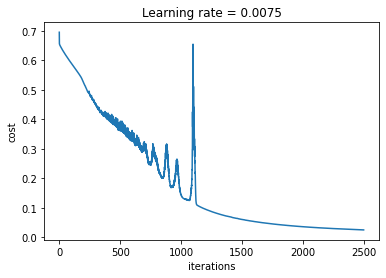

In [242]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate = 0.0075")
plt.show()

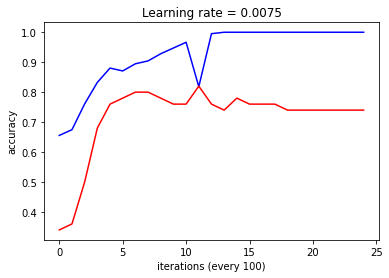

In [243]:
plt.plot(train_accuracies, 'b')
plt.plot(test_accuracies, 'r')
plt.ylabel('accuracy')
plt.xlabel('iterations (every 100)')
plt.title("Learning rate = 0.0075")
plt.show()

In [244]:
print("Final train accuracy = ", train_accuracies[-1])
print("Final test accuracy = ", test_accuracies[-1])

Final train accuracy =  0.9999999999999998
Final test accuracy =  0.74


# 4-Layer Model (Requires smarter parameter initialization)

In [233]:
costs, train_accuracies, test_accuracies = nn_model(train_set_X, train_set_y_orig, test_set_X, test_set_y_orig, [12288, 20, 7, 5, 1], 0.0075, 2500, 100)

Cost after iteration  0  =  0.7717493284237686
Cost after iteration  100  =  0.6720534400822913
Cost after iteration  200  =  0.6482632048575212
Cost after iteration  300  =  0.6115068816101354
Cost after iteration  400  =  0.567047326836611
Cost after iteration  500  =  0.5401376634547801
Cost after iteration  600  =  0.5279299569455267
Cost after iteration  700  =  0.46547737717668514
Cost after iteration  800  =  0.369125852495928
Cost after iteration  900  =  0.39174697434805356
Cost after iteration  1000  =  0.3151869888600617
Cost after iteration  1100  =  0.27269984417893856
Cost after iteration  1200  =  0.23741853400268134
Cost after iteration  1300  =  0.19960120532208644
Cost after iteration  1400  =  0.18926300388463305
Cost after iteration  1500  =  0.1611885466582775
Cost after iteration  1600  =  0.14821389662363316
Cost after iteration  1700  =  0.13777487812972944
Cost after iteration  1800  =  0.1297401754919012
Cost after iteration  1900  =  0.12122535068005211
Cost 

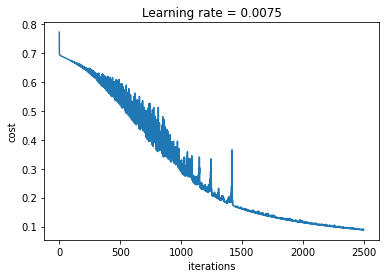

In [234]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate = 0.0075")
plt.show()

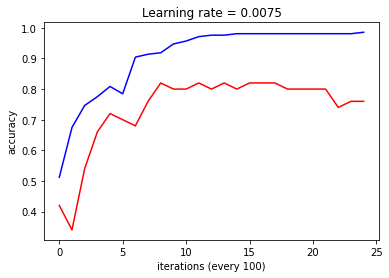

In [235]:
plt.plot(train_accuracies, 'b')
plt.plot(test_accuracies, 'r')
plt.ylabel('accuracy')
plt.xlabel('iterations (every 100)')
plt.title("Learning rate = 0.0075")
plt.show()

In [236]:
print("Final train accuracy = ", train_accuracies[-1])
print("Final test accuracy = ", test_accuracies[-1])

Final train accuracy =  0.9856459330143539
Final test accuracy =  0.76


# Results Analysis

In [248]:
def print_misclassified_images(classes, X, y, predictions):
    a = predictions + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(predictions[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [246]:
test_predictions = predict(test_set_X, parameters)

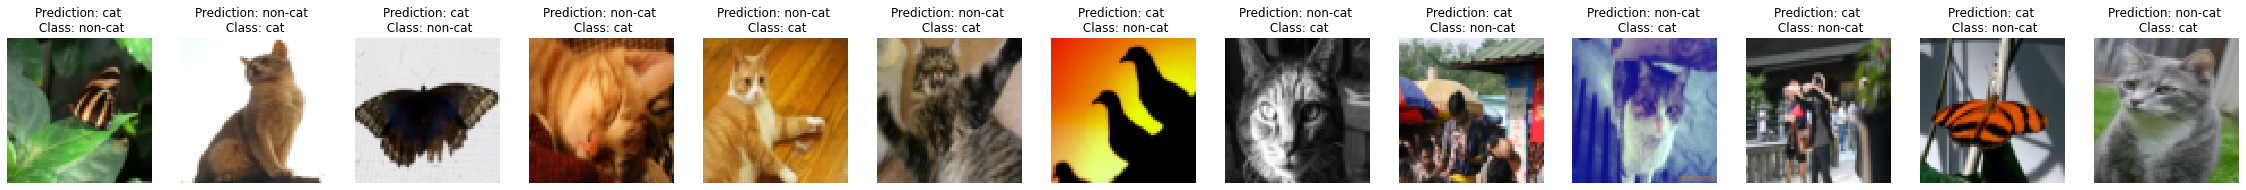

In [249]:
print_misclassified_images(classes, test_set_X, test_set_y_orig, test_predictions)